In [139]:
from j2v import mag
from j2v import w2v
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.stats import binned_statistic
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
from scipy.stats import median_test
from itertools import combinations
from sklearn.neighbors import KernelDensity
%matplotlib inline

In [201]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
model = w2v.load_j2v('../data/100feat_50minwords_10context_2016')


model shape is: (20835, 100) 



In [5]:
jid2vname = mag.get_journal_dict()

processing /l/nx/data/haopeng/j2v/Journals.txt...
finished processing!



In [6]:
mapping = mag.load_map_jid_discipline('journal_discipline_map.csv')

14113 journals in MAG's Journal.txt were matched to UCSD data, and 29 of them are interdisciplinary journals in UCSD catelog.


In [7]:
pid_jid_dict, _ = mag.get_pid_vid_dict('Papers_1950_2000_J.csv')

processing /l/nx/data/haopeng/j2v/Papers_1950_2000_J.csv...
processed 1000000 lines...
processed 2000000 lines...
processed 3000000 lines...
processed 4000000 lines...
processed 5000000 lines...
processed 6000000 lines...
processed 7000000 lines...
processed 8000000 lines...
processed 9000000 lines...
processed 10000000 lines...
processed 11000000 lines...
processed 12000000 lines...
processed 13000000 lines...
processed 14000000 lines...
processed 15000000 lines...
processed 16000000 lines...
processed 17000000 lines...
processed 18000000 lines...
processed 19000000 lines...
processed 20000000 lines...
processed 21000000 lines...
finished processing!

pid2vid dict and year-pid dict are prepared now! It has 21462020 papers!



In [8]:
pid_year = {}
for line in mag.yield_one_line('Papers_1950_2000_J.csv', delimiter=','):
    pid, year, jid, cid = line
    pid_year[pid] = year

processing /l/nx/data/haopeng/j2v/Papers_1950_2000_J.csv...
processed 1000000 lines...
processed 2000000 lines...
processed 3000000 lines...
processed 4000000 lines...
processed 5000000 lines...
processed 6000000 lines...
processed 7000000 lines...
processed 8000000 lines...
processed 9000000 lines...
processed 10000000 lines...
processed 11000000 lines...
processed 12000000 lines...
processed 13000000 lines...
processed 14000000 lines...
processed 15000000 lines...
processed 16000000 lines...
processed 17000000 lines...
processed 18000000 lines...
processed 19000000 lines...
processed 20000000 lines...
processed 21000000 lines...
finished processing!



In [9]:
paper_pr = {}
for line in mag.yield_one_line('pr_pid_1950_2000.csv', delimiter=','):
    pid, pr = line
    paper_pr[pid] = float(pr)

processing /l/nx/data/haopeng/j2v/pr_pid_1950_2000.csv...
processed 1000000 lines...
processed 2000000 lines...
processed 3000000 lines...
processed 4000000 lines...
processed 5000000 lines...
processed 6000000 lines...
processed 7000000 lines...
processed 8000000 lines...
processed 9000000 lines...
processed 10000000 lines...
processed 11000000 lines...
finished processing!



In [10]:
paper_pr_rand = {}
for line in mag.yield_one_line('pr_random_preserve_year_1950_2000.csv', delimiter=','):
    pid, pr = line
    paper_pr_rand[pid] = float(pr)

processing /l/nx/data/haopeng/j2v/pr_random_preserve_year_1950_2000.csv...
processed 1000000 lines...
processed 2000000 lines...
processed 3000000 lines...
processed 4000000 lines...
processed 5000000 lines...
processed 6000000 lines...
processed 7000000 lines...
processed 8000000 lines...
processed 9000000 lines...
processed 10000000 lines...
processed 11000000 lines...
finished processing!



In [11]:
# num. of papers in the largest connected components
len(paper_pr)

11453375

In [12]:
len(paper_pr_rand)

11453158

In [13]:
def journal_spectrum(jids, model, direction):
    dic = {}
    for vid in jids:
        try:
            # dic stores the cosine similarity
            dic[vid] = 1 - cosine(direction, model[vid])
        except: continue
    return dic

def get_direction(model, mapping, disc_domain):
    '''e.g. get direction vector from social center point to mathematical center point.'''
    vid2index = dict((vid, i) for i, vid in enumerate(model.index2word))
    s_ix, n_ix = [], []
    for i in range(len(mapping)):
        jid, disc_name = mapping.iloc[i][['jid', 'disc_name']]
        if disc_name in disc_domain:
            if jid in vid2index:
                ind = vid2index[jid]
                if disc_domain[disc_name] == 'Mathematical':
                    n_ix.append(ind)
                else: s_ix.append(ind)
    math_vec = np.mean(model.syn0[n_ix, :].astype('float64'), axis = 0)
    social_vec = np.mean(model.syn0[s_ix, :].astype('float64'), axis = 0)
    math_vec = math_vec / np.linalg.norm(math_vec)
    social_vec = social_vec / np.linalg.norm(social_vec)
    social2math = math_vec - social_vec
    # it doesn't matter normalize the direction or not.
    # social2natural = social2natural / np.linalg.norm(social2natural)
    return social2math

In [14]:
def get_disc_paper_pr_jids(mapping, paper_pr, disc_list):
    disc_jids = set()
    for i in range(len(mapping)):
        jid, disc_name = mapping.iloc[i][['jid', 'disc_name']]
        if disc_name in disc_list:
            disc_jids.add(jid)
    final_jids = set()
    for pid in paper_pr:
        jid = pid_jid_dict[pid]
        if jid in disc_jids:
            final_jids.add(jid)
    return final_jids

In [15]:
def get_spectrum_pr(paper_pr, j_cosine):
    spectrum_pr = []
    for pid in paper_pr:
        jid = pid_jid_dict[pid]
        if jid in j_cosine:
            spectrum_pr.append([j_cosine[jid], paper_pr[pid]])
    spectrum_pr = np.array(spectrum_pr, dtype = 'float64')
    return spectrum_pr

In [16]:
def get_year_spectrum(paper_pr, j_cosine, pid_year):
    year_spectrum = []
    for pid in paper_pr:
        jid = pid_jid_dict[pid]
        if jid in j_cosine:
            year_spectrum.append([pid_year[pid], j_cosine[jid]])
    year_spectrum = np.array(year_spectrum, dtype='float64')
    return year_spectrum

In [17]:
def plot_two_hexbin_null(spectrum_pr, spectrum_pr_rand, pdf_name):
    fig, (ax1, ax2)= plt.subplots(1, 2, sharex='row', sharey = 'row', figsize=(12, 5))
    # fig.subplots_adjust(left = 0.15, bottom = 0.1)
    hb = ax1.hexbin(spectrum_pr[:, 0], spectrum_pr[:, 1], gridsize=20, bins = 'log', yscale = 'log', cmap='inferno')
    ax1.margins(0)
    cb = fig.colorbar(hb, ax=ax1)
    # cb.set_label('log10(N)')
    ax1.set_xlabel('intensity of basicness')
    ax1.set_ylabel("paper's pagerank value")
    ax1.set_title('Empirical data')

    hb = ax2.hexbin(spectrum_pr_rand[:, 0], spectrum_pr_rand[:, 1], gridsize=15, bins = 'log', yscale = 'log', cmap='inferno')
    ax2.margins(0)
    cb = fig.colorbar(hb, ax=ax2)
    cb.set_label(r'$log_{10}(N)$')
    ax2.set_xlabel('intensity of basicness')
    ax2.set_title('Null model')

    fig.tight_layout()
    fig.subplots_adjust(wspace = 0)
    plt.show()
    fig.savefig(pdf_name, bbox_inches='tight', pad_inches=0)

In [18]:
def plot_two_hexbin(spectrum_pr, year_spectrum, pdf_name):
    fig, (ax1, ax2)= plt.subplots(2, 1, figsize=(6, 8))
    # fig.subplots_adjust(left = 0.15, bottom = 0.1)
    hb = ax1.hexbin(spectrum_pr[:, 0], spectrum_pr[:, 1], gridsize=20, bins = 'log', yscale = 'log', cmap='inferno')
    ax1.margins(0)
    cb = fig.colorbar(hb, ax=ax1)
    cb.set_label(r'$log_{10}(N)$')
    ax1.set_xlabel('intensity of basicness')
    ax1.set_ylabel("paper's pagerank value")
    ax1.set_title('PageRank vs. Spectrum')
    
    df = pd.DataFrame(year_spectrum, columns=['year', 'spectrum'])
    xs = df.groupby('year').mean().index.tolist()
    ys = df.groupby('year').mean()['spectrum'].tolist()
    sd = df.groupby('year').std()['spectrum'].tolist()
    lilen = df.groupby('year').size().tolist()
    h = ax2.hist2d(year_spectrum[:, 0], year_spectrum[:, 1], bins=[len(lilen), 10], normed=True, norm=colors.LogNorm(), cmap = 'inferno')
    cb = fig.colorbar(h[3], ax=ax2)
    # ax.plot(xs, ys, markers[edget], markersize = s, linewidth = lw, label = edget, fillstyle = 'full')
    # 0.99 CI
    ax2.errorbar(xs, ys, yerr=2.576 * np.array(sd)/np.sqrt(lilen), fmt = '-go', markersize = 3, linewidth = 2, fillstyle = 'full')
    
    ax2.set_xlabel('year')
    ax2.set_ylabel('intensity of basicness')
    ax2.set_title('Spectrum vs. Year')
    fig.tight_layout()
    fig.subplots_adjust(wspace = 0)
    plt.show()
    fig.savefig(pdf_name, bbox_inches='tight', pad_inches=0)

In [19]:
def plot_year_spectrum(year_spectrum, pdf_file):
    fig, ax = plt.subplots(figsize = (5,3.5))
    df = pd.DataFrame(year_spectrum, columns=['year', 'spectrum'])
    xs = df.groupby('year').mean()['spectrum'].tolist()
    ys = df.groupby('year').mean().index.tolist()
    sd = df.groupby('year').std()['spectrum'].tolist()
    lilen = df.groupby('year').size().tolist()
    h = ax.hist2d(year_spectrum[:, 1], year_spectrum[:, 0], bins=[10, len(lilen)], normed=True, norm=colors.LogNorm(), cmap = 'inferno')
    cb = fig.colorbar(h[3], ax = ax, fraction=0.05, pad=0.02)
    cb.ax.tick_params(axis='y', direction='in')
    ax.errorbar(xs, ys, xerr=2.576 * np.array(sd)/np.sqrt(lilen), fmt = '-ko', markersize = 3, linewidth = 2, fillstyle = 'full')
    ax.set_ylabel('year')
    ax.text(0, -0.12, '"Soft"', ha='left', va='center', transform=ax.transAxes)
    ax.text(1.0, -0.12, '"Hard"', ha='right', va='center', transform=ax.transAxes)
    plt.show()
    fig.savefig(pdf_file, bbox_inches='tight', pad_inches=0)

In [20]:
def spectrum_kde_top_paper(spectrum_pr, tops, cols, pdf_file, bandwidth = 0.05):
    fig, ax = plt.subplots(figsize = (5,3.5))
    for top, col in zip(tops, cols):
        spectrum_for_top_papers = spectrum_pr[np.argsort(spectrum_pr[:, 1])[-top:], 0]
        X_plot = np.linspace(-0.6, 0.6, 100)
        # grid = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': np.linspace(0.001, 0.01, 20)}, cv=10)
        # grid.fit(spectrum_for_top_papers[:, np.newaxis])
        # print(grid.best_params_)
        # kde = grid.best_estimator_
        kde = KernelDensity(kernel='gaussian', bandwidth = bandwidth).fit(spectrum_for_top_papers[:, np.newaxis])
        pdf = kde.score_samples(X_plot[:, np.newaxis])
        label = 'top %d' %top
        if top == len(spectrum_pr):
            label = 'all papers'
        ax.plot(X_plot, np.exp(pdf), linewidth=2, c = col, label=label)
        # ax.fill(X_plot, np.exp(pdf), fc = '#AAAAFF')
        # ax.hist(spectrum_for_top_papers, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
    legend = ax.legend(loc='best', labelspacing = 0.2, shadow=False, frameon = False)
    ax.set_xlim(-0.6, 0.6)
    ax.set_xlabel('intensity of basicness')
    ax.set_ylabel('pdf')
    ax.set_title('1-D KDE of basicness value of top papers')
    plt.show()
    fig.savefig(pdf_file, bbox_inches='tight', pad_inches=0)

In [131]:
def plot_hexbin_kde(spectrum_pr, spectrum_pr_rand, tops, cols, labels, pdf_name, bandwidth = 0.05):
    fig = plt.figure(figsize=(10, 7.5))
    # the top left subplot
    ax1 = fig.add_subplot(2, 2, 1)
    gs = 9
    hb = ax1.hexbin(spectrum_pr[:, 0], spectrum_pr[:, 1], gridsize=gs, bins = 'log', yscale = 'log', cmap='inferno')
    ax1.margins(0)
    cb = fig.colorbar(hb, ax = ax1, fraction=0.05, pad=0.02)
    cb.set_label(r'$log_{10}(N)$')
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cb.locator = tick_locator
#     cb.update_ticks()
#     cb.ax.set_yticklabels([0, 1, 2, 3, 4])
    cb.ax.tick_params(axis='y', direction='in')
    ax1.set_ylabel("Paper's PageRank value")
    ax1.set_xticklabels([])
    nbins = 10
    MIN, MAX = min(spectrum_pr[:, 1]), max(spectrum_pr[:, 1])
    binseq = 10**np.linspace(np.log10(MIN), np.log10(MAX), nbins)
    means, bin_edges, _ = binned_statistic(spectrum_pr[:, 1], spectrum_pr[:, 0], statistic='mean', bins=binseq)
    stds, _, _ = binned_statistic(spectrum_pr[:, 1], spectrum_pr[:, 0], statistic='std', bins=binseq)
    counts, _, _ = binned_statistic(spectrum_pr[:, 1], spectrum_pr[:, 0], statistic='count', bins=binseq)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_width/2
    # 99% confidence interval
    ax1.errorbar(means, bin_centers, xerr=2.576*stds/np.sqrt(counts), fmt = '-o', color = 'gray', markersize = 3, linewidth = 2)

    # the top right subplot
    ax2 = fig.add_subplot(2, 2, 2)
    hb = ax2.hexbin(spectrum_pr_rand[:, 0], spectrum_pr_rand[:, 1], gridsize=gs, bins = 'log', yscale = 'log', cmap='inferno')
    ax2.margins(0)
    cb = fig.colorbar(hb, ax = ax2, fraction=0.05, pad=0.02)
    cb.set_label(r'$log_{10}(N)$')
#     cb.locator = tick_locator
#     cb.update_ticks()
#     cb.ax.set_yticklabels([0, 1, 2, 3, 4])
    cb.ax.tick_params(axis='y', direction='in')
    ax2.set_xticklabels([])
    nbins = 10
    MIN, MAX = min(spectrum_pr_rand[:, 1]), max(spectrum_pr_rand[:, 1])
    binseq = 10**np.linspace(np.log10(MIN), np.log10(MAX), nbins)
    means, bin_edges, _ = binned_statistic(spectrum_pr_rand[:, 1], spectrum_pr_rand[:, 0], statistic='mean', bins=binseq)
    stds, _, _ = binned_statistic(spectrum_pr_rand[:, 1], spectrum_pr_rand[:, 0], statistic='std', bins=binseq)
    counts, _, _ = binned_statistic(spectrum_pr_rand[:, 1], spectrum_pr_rand[:, 0], statistic='count', bins=binseq)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_width/2
    ax2.errorbar(means, bin_centers, xerr=2.576*stds/np.sqrt(counts), fmt = '-o', color = 'gray', markersize = 3, linewidth = 2)
    
    # the bottom left subplot
    ax3 = fig.add_subplot(2, 2, 3)
    for top, label, col in zip(tops, labels, cols):
        top_nums = int(len(spectrum_pr) * top)
        spectrum_for_top_papers = spectrum_pr[np.argsort(spectrum_pr[:, 1])[-top_nums:], 0]
        X_plot = np.linspace(-0.6, 0.6, 100)
        kde = KernelDensity(kernel='gaussian', bandwidth = bandwidth).fit(spectrum_for_top_papers[:, np.newaxis])
        pdf = kde.score_samples(X_plot[:, np.newaxis])
        ax3.plot(X_plot, np.exp(pdf), linewidth=2, c = col, label=label)
    legend = ax3.legend(loc="upper left", bbox_to_anchor=(0.03, 1), labelspacing = 0.2, shadow=False, frameon = False)
    xmin, xmax = ax1.get_xlim()
    ax3.set_xlim(xmin, xmax)
    if pdf_name not in ['panel-biotechnology.pdf', 'panel-earth.pdf']:
        ax3.set_ylim(-0.2, 5)
    if pdf_name == 'panel-life.pdf':
        ax3.set_ylim(-0.2, 4)
    ax3.text(0, -0.15, '"Soft"', ha='left', va='center', transform=ax3.transAxes)
    ax3.text(1.0, -0.15, '"Hard"', ha='right', va='center', transform=ax3.transAxes)
    ax3.set_ylabel('PDF')
    ax3_divider = make_axes_locatable(ax3)
    cax3 = ax3_divider.append_axes("right", size="5%", pad="2%")
    cax3.spines['right'].set_visible(False)
    cax3.spines['top'].set_visible(False)
    cax3.spines['bottom'].set_visible(False)
    cax3.spines['left'].set_visible(False)
    cax3.axes.get_xaxis().set_visible(False)
    cax3.axes.get_yaxis().set_visible(False)
    
    # the bottom right subplot
    ax4 = fig.add_subplot(2, 2, 4)
    for top, label, col in zip(tops, labels, cols):
        top_nums = int(len(spectrum_pr_rand) * top)
        spectrum_rand_for_top_papers = spectrum_pr_rand[np.argsort(spectrum_pr_rand[:, 1])[-top_nums:], 0]
        X_plot = np.linspace(-0.6, 0.6, 100)
        kde = KernelDensity(kernel='gaussian', bandwidth = bandwidth).fit(spectrum_rand_for_top_papers[:, np.newaxis])
        pdf = kde.score_samples(X_plot[:, np.newaxis])
        ax4.plot(X_plot, np.exp(pdf), linewidth=2, c = col, label=label)
    # legend = ax4.legend(loc=[0.15, 0.78], labelspacing = 0.2, shadow=False, frameon = False)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax3.get_ylim()
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(ymin, ymax)
    ax4.text(0, -0.15, '"Soft"', ha='left', va='center', transform=ax4.transAxes)
    ax4.text(1.0, -0.15, '"Hard"', ha='right', va='center', transform=ax4.transAxes)
    ax4_divider = make_axes_locatable(ax4)
    cax4 = ax4_divider.append_axes("right", size="5%", pad="2%")
    cax4.spines['right'].set_visible(False)
    cax4.spines['top'].set_visible(False)
    cax4.spines['bottom'].set_visible(False)
    cax4.spines['left'].set_visible(False)
    cax4.axes.get_xaxis().set_visible(False)
    cax4.axes.get_yaxis().set_visible(False)
    
    # labels
    labels = ['a', 'c', 'b', 'd']
    # labels = ['e', 'g', 'f', 'h']
    axes = [ax1, ax2, ax3, ax4]
    xs = [-0.25, -0.25, -0.25, -0.25]
    # xs = [-0.23, -0.23, -0.23, -0.23]
    y = 1.00
    for ax, label, x in zip(axes, labels, xs):
        ax.text(x, y, label, ha='left', va='top', transform=ax.transAxes)
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.1)
    plt.show()
    fig.savefig(pdf_name, bbox_inches='tight', pad_inches=0.01)

In [214]:
# for generating fig. 4 in the main text.
def plot_hexbin_kde(spectrum_pr, spectrum_pr_rand, tops, cols, labels, pdf_name, bandwidth = 0.05):
    fig = plt.figure(figsize=(10, 7.5))
    # the top left subplot
    ax1 = fig.add_subplot(2, 2, 1)
    gs = 9
    hb = ax1.hexbin(spectrum_pr[:, 0], spectrum_pr[:, 1], gridsize=gs, bins = 'log', yscale = 'log', cmap='inferno')
    ax1.margins(0)
    cb = fig.colorbar(hb, ax = ax1, fraction=0.05, pad=0.02)
    cb.set_label(r'$log_{10}(N)$')
    cb.ax.tick_params(axis='y', direction='in')
    ax1.set_ylabel("PageRank Scores")
    ax1.set_xticklabels([])
    nbins = 10
    MIN, MAX = min(spectrum_pr[:, 1]), max(spectrum_pr[:, 1])
    binseq = 10**np.linspace(np.log10(MIN), np.log10(MAX), nbins)
    means, bin_edges, _ = binned_statistic(spectrum_pr[:, 1], spectrum_pr[:, 0], statistic='mean', bins=binseq)
    stds, _, _ = binned_statistic(spectrum_pr[:, 1], spectrum_pr[:, 0], statistic='std', bins=binseq)
    counts, _, _ = binned_statistic(spectrum_pr[:, 1], spectrum_pr[:, 0], statistic='count', bins=binseq)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_width/2
    # 99% confidence interval
    ax1.errorbar(means, bin_centers, xerr=2.576*stds/np.sqrt(counts), fmt = '-o', color = 'gray', markersize = 3, linewidth = 2)

    # the top right subplot
    ax2 = fig.add_subplot(2, 2, 2)
    hb = ax2.hexbin(spectrum_pr_rand[:, 0], spectrum_pr_rand[:, 1], gridsize=gs, bins = 'log', yscale = 'log', cmap='inferno')
    ax2.margins(0)
    cb = fig.colorbar(hb, ax = ax2, fraction=0.05, pad=0.02)
    cb.set_label(r'$log_{10}(N)$')
    if pdf_name == 'panel-eecs.pdf':
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.set_yticklabels([0, 1, 2, 3, 4])
    cb.ax.tick_params(axis='y', direction='in')
    ax2.set_xticklabels([])
    nbins = 10
    MIN, MAX = min(spectrum_pr_rand[:, 1]), max(spectrum_pr_rand[:, 1])
    binseq = 10**np.linspace(np.log10(MIN), np.log10(MAX), nbins)
    means, bin_edges, _ = binned_statistic(spectrum_pr_rand[:, 1], spectrum_pr_rand[:, 0], statistic='mean', bins=binseq)
    stds, _, _ = binned_statistic(spectrum_pr_rand[:, 1], spectrum_pr_rand[:, 0], statistic='std', bins=binseq)
    counts, _, _ = binned_statistic(spectrum_pr_rand[:, 1], spectrum_pr_rand[:, 0], statistic='count', bins=binseq)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_width/2
    ax2.errorbar(means, bin_centers, xerr=2.576*stds/np.sqrt(counts), fmt = '-o', color = 'gray', markersize = 3, linewidth = 2)
    
    # the bottom left subplot
    ax3 = fig.add_subplot(2, 2, 3)
    for top, label, col in zip(tops, labels, cols):
        top_nums = int(len(spectrum_pr) * top)
        spectrum_for_top_papers = spectrum_pr[np.argsort(spectrum_pr[:, 1])[-top_nums:], 0]
        X_plot = np.linspace(-0.6, 0.6, 100)
        kde = KernelDensity(kernel='gaussian', bandwidth = bandwidth).fit(spectrum_for_top_papers[:, np.newaxis])
        pdf = kde.score_samples(X_plot[:, np.newaxis])
        ax3.plot(X_plot, np.exp(pdf), linewidth=2, c = col, label=label)
    legend = ax3.legend(loc="upper left", bbox_to_anchor=(0.03, 1), labelspacing = 0.2, shadow=False, frameon = False)
    xmin, xmax = ax1.get_xlim()
    ax3.set_xlim(xmin, xmax)
    if pdf_name not in ['panel-biotechnology.pdf', 'panel-earth.pdf']:
        ax3.set_ylim(-0.2, 5)
    if pdf_name == 'panel-life.pdf':
        ax3.set_ylim(-0.2, 4)
    ax3.text(0, -0.18, '"Soft"', ha='left', va='center', transform=ax3.transAxes)
    ax3.text(1.0, -0.18, '"Hard"', ha='right', va='center', transform=ax3.transAxes)
    ax3.set_ylabel('PDF')
    ax3_divider = make_axes_locatable(ax3)
    cax3 = ax3_divider.append_axes("right", size="5%", pad="2%")
    cax3.spines['right'].set_visible(False)
    cax3.spines['top'].set_visible(False)
    cax3.spines['bottom'].set_visible(False)
    cax3.spines['left'].set_visible(False)
    cax3.axes.get_xaxis().set_visible(False)
    cax3.axes.get_yaxis().set_visible(False)
    
    # the bottom right subplot
    ax4 = fig.add_subplot(2, 2, 4)
    for top, label, col in zip(tops, labels, cols):
        top_nums = int(len(spectrum_pr_rand) * top)
        spectrum_rand_for_top_papers = spectrum_pr_rand[np.argsort(spectrum_pr_rand[:, 1])[-top_nums:], 0]
        X_plot = np.linspace(-0.6, 0.6, 100)
        kde = KernelDensity(kernel='gaussian', bandwidth = bandwidth).fit(spectrum_rand_for_top_papers[:, np.newaxis])
        pdf = kde.score_samples(X_plot[:, np.newaxis])
        ax4.plot(X_plot, np.exp(pdf), linewidth=2, c = col, label=label)
    # legend = ax4.legend(loc=[0.15, 0.78], labelspacing = 0.2, shadow=False, frameon = False)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax3.get_ylim()
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(ymin, ymax)
    ax4.text(0, -0.18, '"Soft"', ha='left', va='center', transform=ax4.transAxes)
    ax4.text(1.0, -0.18, '"Hard"', ha='right', va='center', transform=ax4.transAxes)
    ax4_divider = make_axes_locatable(ax4)
    cax4 = ax4_divider.append_axes("right", size="5%", pad="2%")
    cax4.spines['right'].set_visible(False)
    cax4.spines['top'].set_visible(False)
    cax4.spines['bottom'].set_visible(False)
    cax4.spines['left'].set_visible(False)
    cax4.axes.get_xaxis().set_visible(False)
    cax4.axes.get_yaxis().set_visible(False)
    
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.1)
    plt.show()
    fig.savefig(pdf_name, bbox_inches='tight', pad_inches=0.01)

In [170]:
def ks_test_a_pair(top):
    top_size_empr = int(len(spectrum_pr) * top)
    top_size_null = int(len(spectrum_pr_rand) * top)
    spectrums_empr = spectrum_pr[np.argsort(spectrum_pr[:, 1])[-top_size_empr:], 0]
    spectrums_null = spectrum_pr_rand[np.argsort(spectrum_pr_rand[:, 1])[-top_size_null:], 0]
    kl_stat, kl_p = ks_2samp(spectrums_empr, spectrums_null)
    mean_stat, mean_p = ttest_ind(spectrums_empr, spectrums_null)
    med_stat, med_p, med, tbl = median_test(spectrums_empr, spectrums_null)
    mean_emp = np.mean(spectrums_empr)
    mean_null = np.mean(spectrums_null)
    median_emp = np.median(spectrums_empr)
    median_null = np.median(spectrums_null)
    print('\t %f emp vs. null (KL_pval=%f):'%(top, kl_p))
    print('\t\t mean: %f, %f \t delta: %f (%f)'%(mean_emp, mean_null, mean_emp-mean_null, mean_p))
    print('\t\t median: %f, %f \t delta: %f (%f)'%(median_emp, median_null, median_emp-median_null, med_p))

## soft - hard

In [199]:
# cols = ['k', 'b', 'g']
cols = ['#D3D3D3', '#808080', '#000000']
tops = [1, 0.01, 0.001]
labels = ['all', 'top 1%', 'top 0.1%']

In [22]:
disc_domain = {'Math & Physics': 'Mathematical', 'Social Sciences': 'Social', 'Humanities': 'Social'}

In [23]:
# mean of all journal vectors in a group as the center point.
direction = get_direction(model, mapping, disc_domain)

#### Statistical test

In [172]:
for disc in w2v.dis2color.keys():
    if disc != 'Interdiscipline':
        discs = [disc]
        disc_paper_pr_jids = get_disc_paper_pr_jids(mapping, paper_pr, discs)
        j_cosine = journal_spectrum(disc_paper_pr_jids, model, direction)
        spectrum_pr = get_spectrum_pr(paper_pr, j_cosine)
        spectrum_pr_rand = get_spectrum_pr(paper_pr_rand, j_cosine)
        print(disc)
        print('\t num. of journals: %d'%len(j_cosine))
        print('\t num. of papers: %d'%(len(spectrum_pr)))
        for top in tops[1:]:
            ks_test_a_pair(top)
        print()

Brain Research
	 num. of journals: 578
	 num. of papers: 699799
	 0.010000 emp vs. null (KL_pval=0.000000):
		 mean: 0.029129, 0.005067 	 delta: 0.024062 (0.000000)
		 median: 0.080340, 0.007593 	 delta: 0.072747 (0.000000)
	 0.001000 emp vs. null (KL_pval=0.000000):
		 mean: 0.011553, 0.009193 	 delta: 0.002360 (0.732614)
		 median: 0.080340, 0.007593 	 delta: 0.072747 (0.000000)

Medical Specialties
	 num. of journals: 1224
	 num. of papers: 1822771
	 0.010000 emp vs. null (KL_pval=0.000000):
		 mean: 0.050362, 0.021673 	 delta: 0.028689 (0.000000)
		 median: 0.038807, 0.029052 	 delta: 0.009755 (0.000000)
	 0.001000 emp vs. null (KL_pval=0.000000):
		 mean: 0.061822, 0.012661 	 delta: 0.049161 (0.000000)
		 median: 0.051026, 0.024943 	 delta: 0.026083 (0.000000)

Health Professionals
	 num. of journals: 1040
	 num. of papers: 720726
	 0.010000 emp vs. null (KL_pval=0.000000):
		 mean: -0.041659, -0.064434 	 delta: 0.022775 (0.000000)
		 median: -0.004902, -0.004902 	 delta: 0.000000

#### Panel plot

Life Sciences (5 disciplines combined)

In [231]:
discs = ['Biology', 'Biotechnology', 'Medical Specialties', 'Health Professionals', 'Infectious Diseases']

In [232]:
disc_paper_pr_jids = get_disc_paper_pr_jids(mapping, paper_pr, discs)
# some matched jid may not be in the model
j_cosine = journal_spectrum(disc_paper_pr_jids, model, direction)
spectrum_pr = get_spectrum_pr(paper_pr, j_cosine)
spectrum_pr_rand = get_spectrum_pr(paper_pr_rand, j_cosine)
year_spectrum = get_year_spectrum(paper_pr, j_cosine, pid_year)

In [1]:
import matplotlib
matplotlib.style.use('default')
plot_year_spectrum(pdf_file='life-yearly-hardness.pdf', year_spectrum = year_spectrum)

In [189]:
for top in tops[1:]:
    ks_test_a_pair(top)

	 0.010000 emp vs. null (KL_pval=0.000000):
		 mean: 0.094931, 0.057737 	 delta: 0.037194 (0.000000)
		 median: 0.083195, 0.061951 	 delta: 0.021245 (0.000000)
	 0.001000 emp vs. null (KL_pval=0.000000):
		 mean: 0.120429, 0.051882 	 delta: 0.068547 (0.000000)
		 median: 0.142860, 0.051783 	 delta: 0.091077 (0.000000)


In [ ]:
print('num. of journals: %d'%len(j_cosine))
print('num. of papers: %d'%(len(spectrum_pr)))
plot_hexbin_kde(spectrum_pr, spectrum_pr_rand, tops, cols, labels, pdf_name='panel-life.pdf')

num. of journals: 3775
num. of papers: 4332159


For each individual discipline

In [184]:
dis_name_abbr = {'Brain Research': 'brain', 'Medical Specialties': 'medical', 'Health Professionals': 'health', 'Social Sciences': 'social', 'Earth Sciences': 'earth', 'Biology': 'biology', 'Chemical, Mechanical, & Civil Engineering': 'eng', 'Chemistry': 'chem', 'Biotechnology': 'biotechnology', 'Infectious Diseases': 'infectious', 'Math & Physics': 'math-phy', 'Humanities': 'human', 'Electrical Engineering & Computer Science': 'eecs'}

Brain Research


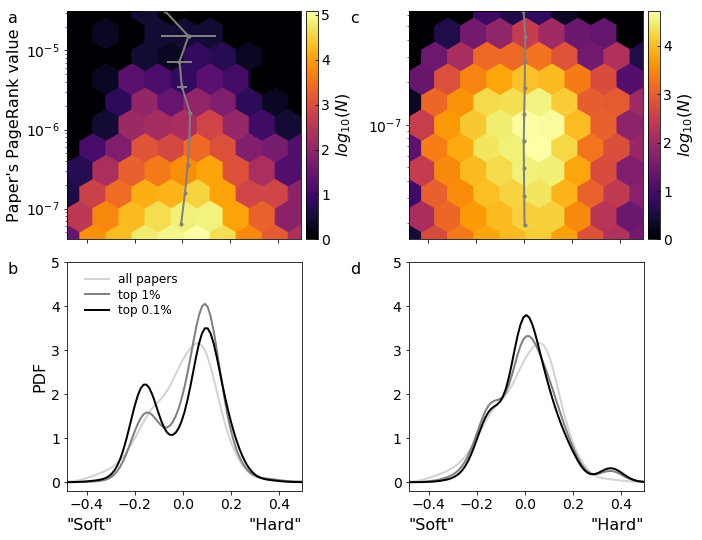

Medical Specialties


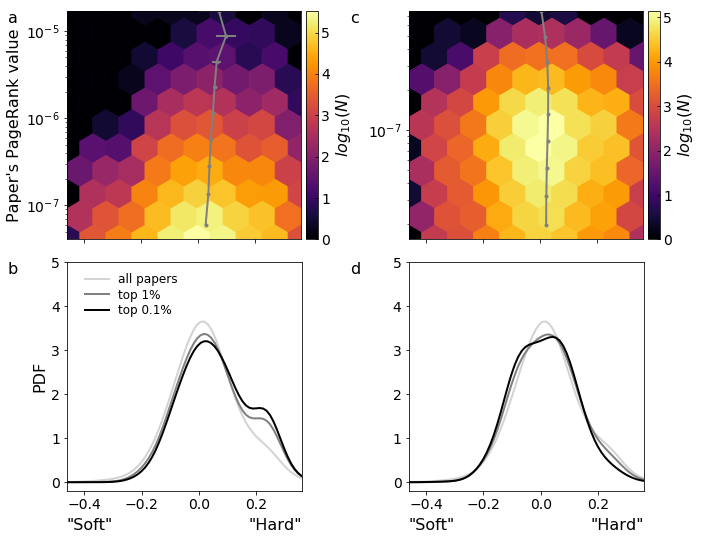

Health Professionals


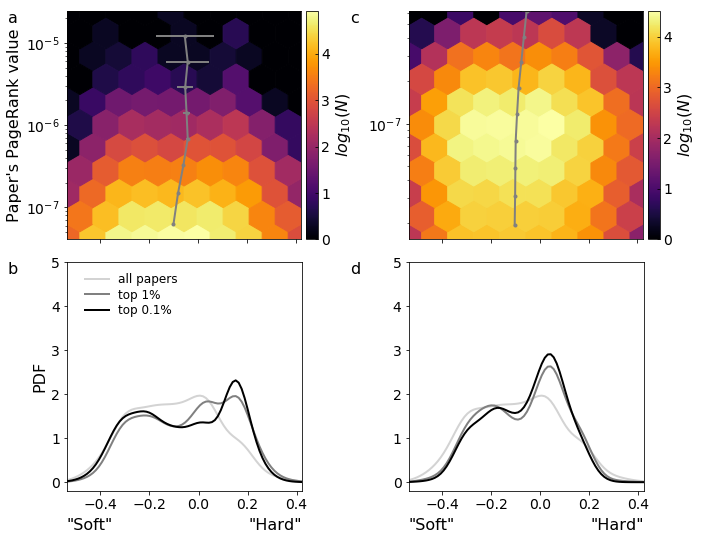

Social Sciences


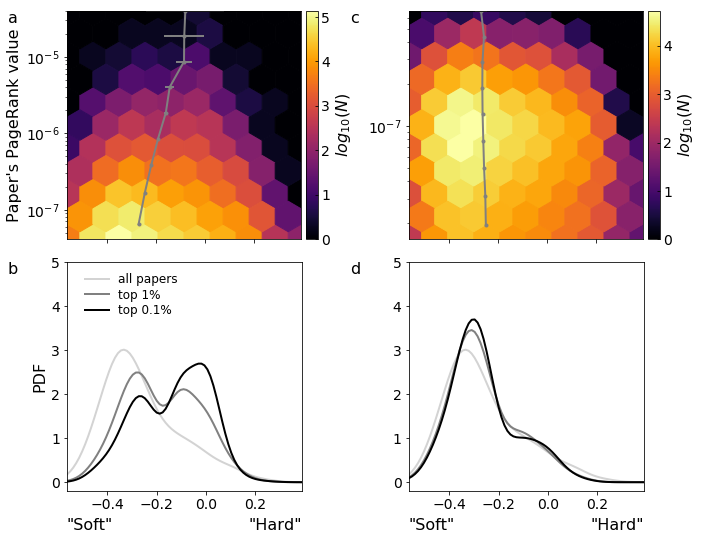

Earth Sciences


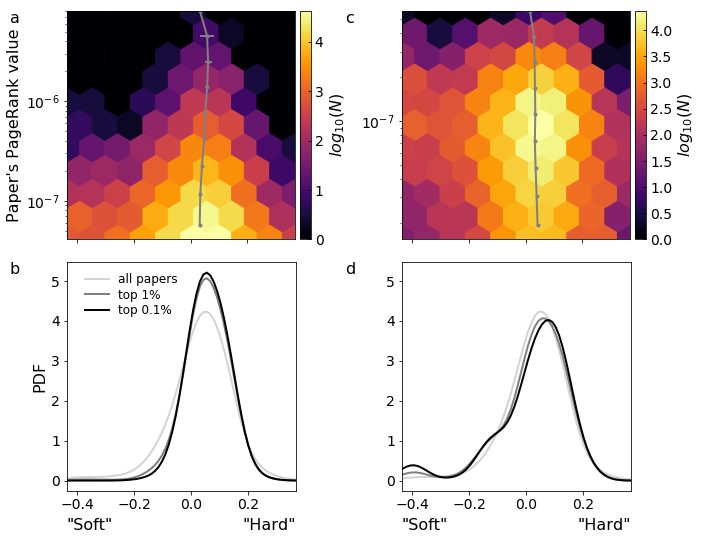

Biology


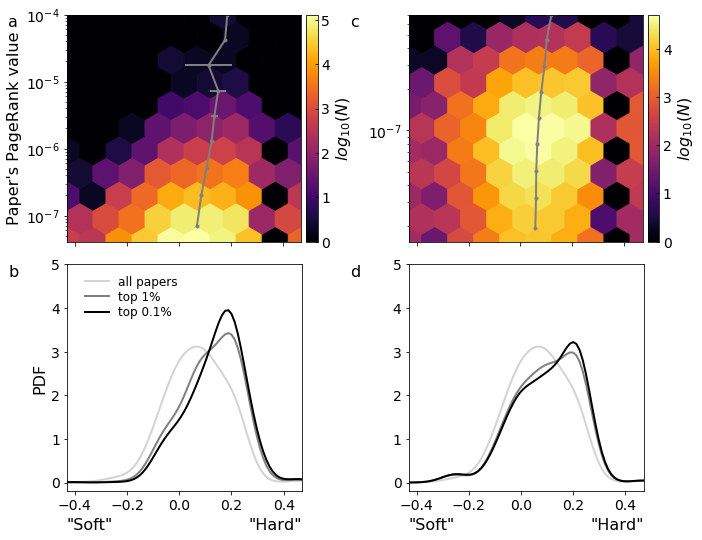

Chemical, Mechanical, & Civil Engineering


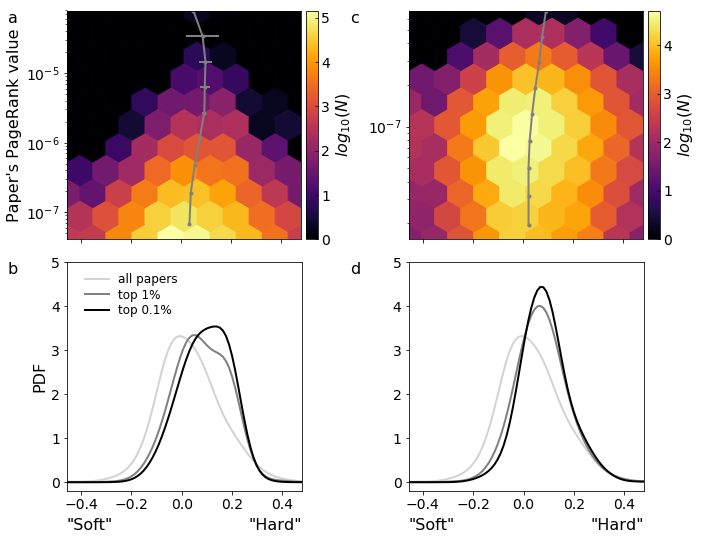

Chemistry


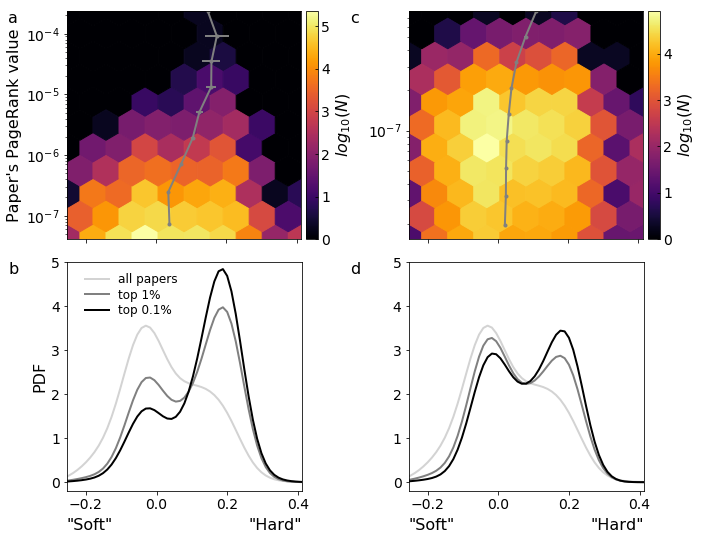

Biotechnology


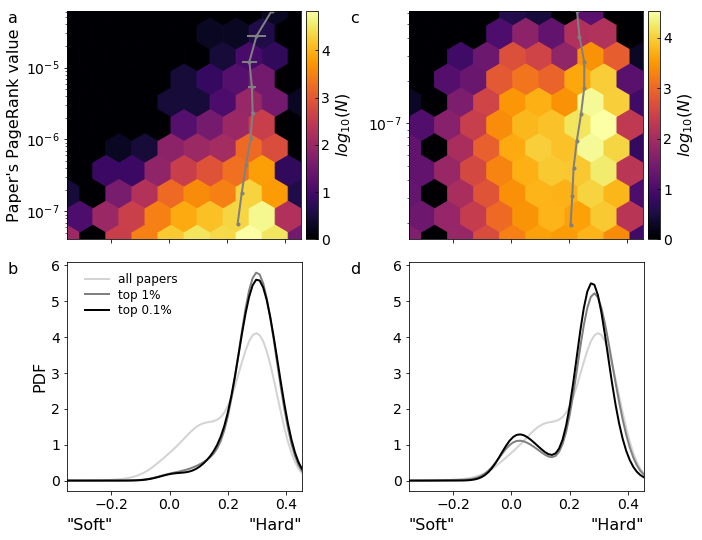

Infectious Diseases


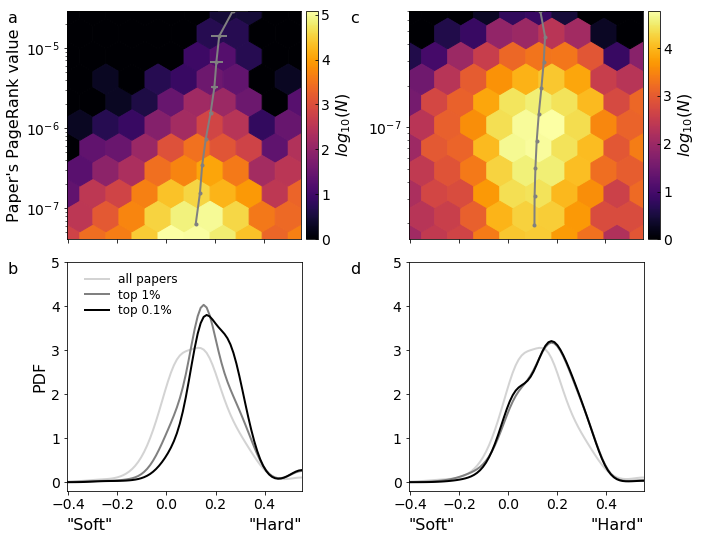

Math & Physics


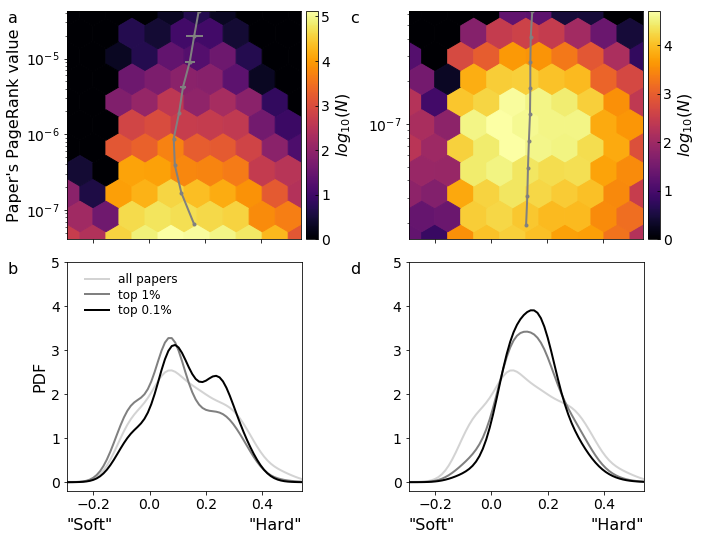

Humanities


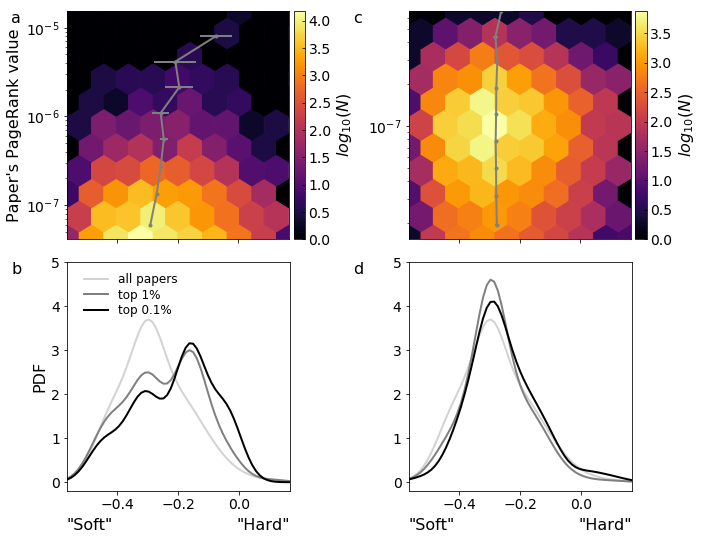

Electrical Engineering & Computer Science


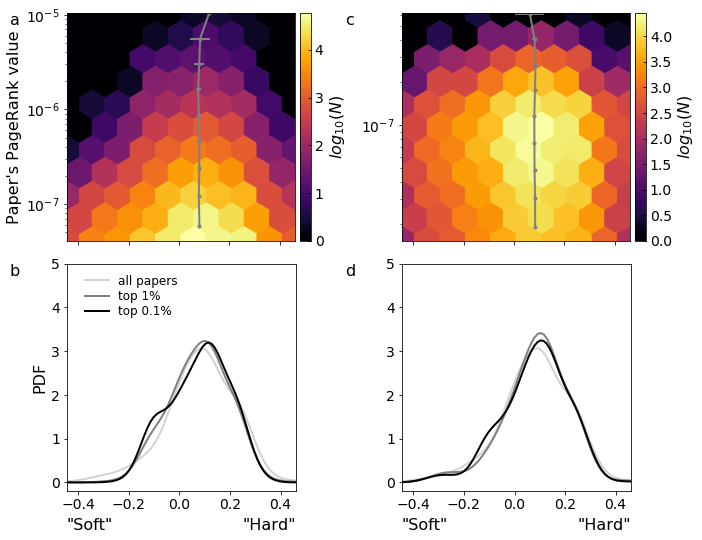

In [185]:
for disc in w2v.dis2color.keys():
    if disc != 'Interdiscipline':
        discs = [disc]
        disc_paper_pr_jids = get_disc_paper_pr_jids(mapping, paper_pr, discs)
        j_cosine = journal_spectrum(disc_paper_pr_jids, model, direction)
        spectrum_pr = get_spectrum_pr(paper_pr, j_cosine)
        spectrum_pr_rand = get_spectrum_pr(paper_pr_rand, j_cosine)
        print(disc)
        plot_hexbin_kde(spectrum_pr, spectrum_pr_rand, tops, cols, labels, pdf_name='panel-%s.pdf'%(dis_name_abbr[disc]))